In [6]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
from cv2 import resize

# Load data, initialization, etc.

In [8]:
(train_input, train_class), (test_input, test_class) = keras.datasets.mnist.load_data()
train_size = train_input.shape[0]
test_size = test_input.shape[0]
input_shape = train_input.shape[1:]
num_classes = np.unique(train_class).shape[0]
flattened_shape = 1
for dim in input_shape:
    flattened_shape *= dim

print('We have {} training images and {} testing images.'.format(train_size, test_size))

We have 60000 training images and 10000 testing images.


Images looks like the following:

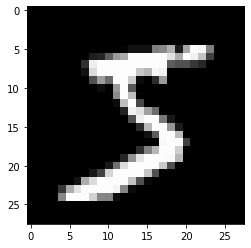

In [9]:
plt.imshow(train_input[0], cmap='gray');

Here we clean the data to how we want it.  By default, each image in MNIST is a 28x28 grid of integers ranging from 0 to 255 representing the color of the pixel.  It is preferable to have inputs of neural networks be near 0, so we center the data to 0 and decrease the range.

We also change the outputs to be identity vectors instead of the integers themselves.

In [10]:
train_input = (train_input/255 - 0.5).astype('float32')
test_input = (test_input/255 - 0.5).astype('float32')

train_y = np.zeros(shape=(train_size, num_classes))
for i in range(train_size):
    train_y[i][train_class[i]] = 1

test_y = np.zeros(shape=(test_size, num_classes))
for i in range(test_size):
    test_y[i][test_class[i]] = 1

In [11]:
batch_size = 64
epochs = 20

# Fully Connected Neural Network

First, we will start with a neural network with no hidden layers whatsoever.  This is effectively a linear model as the only nonlinearity comes in at the end with the Softmax Function.

Speaking of which, the ideal activation function for the output is in fact softmax:

$$ \sigma (x)_i = \dfrac{e^{x_i}}{\sum _{j} e^{x_j}}. $$

What this function does is take a vector and transform it to a probability space, that is, a vector s.t. $\sigma (x)_i \in \left[ 0, 1\right]$ and $\sum _{i} \sigma (x)_i = 1$.

This is easy to see since $\forall x \in \mathbb{R}$, $e^{x} > 0$ , thus $\sigma (x)_i \geq 0$.  For the same reason, $e^{x_i} \leq \sum _j e^{x_j}$, so $\sigma (x)_i \leq 1$.  Finally we have

$$ \sum _i \sigma (x)_i = \sum _i \dfrac{e^{x_i}}{\sum _{j} e^{x_j}} = \dfrac{\sum _i e^{x_i}}{\sum _{i} e^{x_i}} = 1.$$

The result of applying this function to the final layer of a neural network is that we can now easily interpret the output vector simply.  The output $y$ of the model means that there is a $y_i$ probability that the input is the $i$th class.

In [6]:
def model_maker():
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(28, 28)),
            keras.layers.Dense(num_classes, keras.activations.softmax)])
    model.compile(optimizer='adam',
                  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics='accuracy')
    return model

model = model_maker()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


We split the training data so that we have validation data as well.  This helps us know how are model is doing without utilizing the testing data, as well as acts as a great way to check for overfitting.

We also define an EarlyStopping callback.  If the model doesn't continue to improve, we stop training as to a) not overfit and b) speed up the training process.  If we don't see an improvement in the accuracy of the validation data of min_delta over patience epochs, we quit.

In [7]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=.001, patience=3)
model.fit(train_input, train_class, batch_size=batch_size, epochs=epochs, verbose=1,
      validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[callback]);

Epoch 1/20
750/750 [==============================] - 1s 1ms/step - loss: 0.9766 - accuracy: 0.7231 - val_loss: 0.3774 - val_accuracy: 0.8934
Epoch 2/20
750/750 [==============================] - 1s 811us/step - loss: 0.3798 - accuracy: 0.8911 - val_loss: 0.3238 - val_accuracy: 0.9066
Epoch 3/20
750/750 [==============================] - 1s 858us/step - loss: 0.3369 - accuracy: 0.9031 - val_loss: 0.3041 - val_accuracy: 0.9113
Epoch 4/20
750/750 [==============================] - 1s 856us/step - loss: 0.3224 - accuracy: 0.9069 - val_loss: 0.3003 - val_accuracy: 0.9151
Epoch 5/20
750/750 [==============================] - 1s 810us/step - loss: 0.3068 - accuracy: 0.9136 - val_loss: 0.2952 - val_accuracy: 0.9162
Epoch 6/20
750/750 [==============================] - 1s 827us/step - loss: 0.3008 - accuracy: 0.9126 - val_loss: 0.2902 - val_accuracy: 0.9193
Epoch 7/20
750/750 [==============================] - 1s 823us/step - loss: 0.2966 - accuracy: 0.9166 - val_loss: 0.2828 - val_accuracy: 0

In [8]:
loss, acc = model.evaluate(test_input, test_class)
print('This model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

313/313 [==============================] - 0s 438us/step - loss: 0.2911 - accuracy: 0.9163
This model had a loss of 0.291 and a total accuracy of 91.63%.


As you can see, even with only 7850 parameters and truly nothing special going on, this model can achieve over 90% accuracy.  However, we can do significantly better by expanding the size of our neural network.

# Adding Hidden Layers

The easiest way to increase the power of our neural network is to add hidden layers.  These are layers of nodes that act as inbetweens between the input nodes and the output nodes.  We will just use the ReLu activation function for these as it is cheap to compute both the function and its derivative:
$$ relu(x) = \max(0,x), relu'(x) = \max \left( 0, \dfrac{x}{|x|} \right), x\neq 0.$$

In [9]:
def hidden_model_maker():
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(28, 28)),
            keras.layers.Dense(64, keras.activations.relu),
            keras.layers.Dense(32, keras.activations.relu),
            keras.layers.Dense(num_classes, keras.activations.softmax)])
    model.compile(optimizer='adam',
                  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics='accuracy')
    return model

hidden_model = hidden_model_maker()
hidden_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [10]:
hidden_model.fit(train_input, train_class, batch_size=batch_size, epochs=epochs, verbose=1,
      validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[callback]);

Epoch 1/20
750/750 [==============================] - 1s 1ms/step - loss: 0.8084 - accuracy: 0.7600 - val_loss: 0.2709 - val_accuracy: 0.9227
Epoch 2/20
750/750 [==============================] - 1s 968us/step - loss: 0.2613 - accuracy: 0.9223 - val_loss: 0.2038 - val_accuracy: 0.9405
Epoch 3/20
750/750 [==============================] - 1s 1ms/step - loss: 0.2062 - accuracy: 0.9388 - val_loss: 0.1859 - val_accuracy: 0.9466
Epoch 4/20
750/750 [==============================] - 1s 1ms/step - loss: 0.1718 - accuracy: 0.9473 - val_loss: 0.1681 - val_accuracy: 0.9507
Epoch 5/20
750/750 [==============================] - 1s 1ms/step - loss: 0.1474 - accuracy: 0.9569 - val_loss: 0.1634 - val_accuracy: 0.9500
Epoch 6/20
750/750 [==============================] - 1s 1ms/step - loss: 0.1275 - accuracy: 0.9630 - val_loss: 0.1659 - val_accuracy: 0.9501
Epoch 7/20
750/750 [==============================] - 1s 1ms/step - loss: 0.1269 - accuracy: 0.9608 - val_loss: 0.1431 - val_accuracy: 0.9583
Epoc

In [11]:
loss, acc = hidden_model.evaluate(test_input, test_class)
print('This model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

313/313 [==============================] - 0s 524us/step - loss: 0.1365 - accuracy: 0.9586
This model had a loss of 0.136 and a total accuracy of 95.86%.


Clearly this is doing a bit better, but we're still not at human level (which would be basically 100%).  To fix this, we add Convolutional Layers.

# Adding Convolutional Layers

Convolutional Layers are layers designed to extract spatial information from data.  This inherently makes convolutional layers invaluable for image classification problems.  We will also add Max Pooling layers inbetween as they reduce the dimensions quickly, and Dropout layers to help with overfitting.

In [12]:
def conv_model_maker():
    model = keras.Sequential([
            keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation=keras.activations.relu, input_shape=(28,28,1)),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation=keras.activations.relu),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation=keras.activations.relu),
#             keras.layers.MaxPool2D(),
            
            keras.layers.Flatten(),
            keras.layers.Dropout(0.1),
            keras.layers.Dense(64, keras.activations.relu),
            keras.layers.Dropout(0.1),
            keras.layers.Dense(32, keras.activations.relu),
            keras.layers.Dense(num_classes, keras.activations.softmax)])
    model.compile(optimizer='adam',
                  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics='accuracy')
    return model

conv_model = conv_model_maker()
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1152)              0

By the nature of convolutional neural networks in tensorflow, we must change the shape of the data.

In [13]:
conv_train_input = tf.expand_dims(train_input, -1)
conv_test_input = tf.expand_dims(test_input, -1)
print(conv_train_input.shape)
print(conv_test_input.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [14]:
conv_model.fit(conv_train_input, train_class, batch_size=batch_size, epochs=epochs, verbose=1,
      validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[callback]);

Epoch 1/20
750/750 [==============================] - 15s 19ms/step - loss: 0.6548 - accuracy: 0.7770 - val_loss: 0.0659 - val_accuracy: 0.9804
Epoch 2/20
750/750 [==============================] - 14s 19ms/step - loss: 0.0737 - accuracy: 0.9773 - val_loss: 0.0517 - val_accuracy: 0.9845
Epoch 3/20
750/750 [==============================] - 14s 19ms/step - loss: 0.0478 - accuracy: 0.9854 - val_loss: 0.0424 - val_accuracy: 0.9886
Epoch 4/20
750/750 [==============================] - 15s 20ms/step - loss: 0.0360 - accuracy: 0.9890 - val_loss: 0.0395 - val_accuracy: 0.9889
Epoch 5/20
750/750 [==============================] - 14s 19ms/step - loss: 0.0282 - accuracy: 0.9911 - val_loss: 0.0396 - val_accuracy: 0.9887
Epoch 6/20
750/750 [==============================] - 14s 19ms/step - loss: 0.0246 - accuracy: 0.9929 - val_loss: 0.0412 - val_accuracy: 0.9888


In [15]:
loss, acc = conv_model.evaluate(conv_test_input, test_class)
print('This model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

313/313 [==============================] - 1s 3ms/step - loss: 0.0334 - accuracy: 0.9905
This model had a loss of 0.033 and a total accuracy of 99.05%.


This model is nearly perfect on the dataset.  Next, we see just how good we can get this model to do with this type of data.

# Adding Noise to our dataset

Now, we can start adding noise to our data to see how noise-proof our model is.  There are two types of noise we will introduce here.  One we will call Blackout noise, where some number of pixels are either white or black randomly regardless of their previous color, and the other we will call Standard noise, where we add a gaussian amount of noise to each pixel.  We will start with Blackout noise.

Here we simply take a portion of all pixels and make them np.max(data) (for us 0.5).

In [16]:
def blackout_noise(data, blackout_prop=0.4):
    pixel_changers = np.random.binomial(size=data.shape, n=1, p=blackout_prop)
    data += pixel_changers
    data = tf.clip_by_value(data, -0.5, 0.5)
    return data

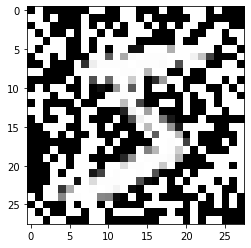

In [17]:
blackout_train = blackout_noise(conv_train_input)
blackout_test = blackout_noise(conv_test_input)
_ = plt.imshow(blackout_train[0], cmap='gray')

Note that we lose in incredible of accuracy when using the previously trained model that we never introduced noise to:

In [18]:
loss, acc = conv_model.evaluate(blackout_test, test_class)
print('For 40% blacked out data, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

313/313 [==============================] - 1s 3ms/step - loss: 3.1624 - accuracy: 0.2137
For 40% blacked out data, this model had a loss of 3.162 and a total accuracy of 21.37%.


We will use the same type of model as we did previously but train it on this new data and see how well it does both on clean and blacked out test data.

In [19]:
blackout_model = conv_model_maker()
blackout_model.fit(blackout_train, train_class, batch_size=batch_size, epochs=epochs, verbose=1,
      validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[callback]);

Epoch 1/20
750/750 [==============================] - 15s 19ms/step - loss: 0.9432 - accuracy: 0.6846 - val_loss: 0.1431 - val_accuracy: 0.9571
Epoch 2/20
750/750 [==============================] - 15s 20ms/step - loss: 0.1615 - accuracy: 0.9502 - val_loss: 0.1011 - val_accuracy: 0.9668
Epoch 3/20
750/750 [==============================] - 14s 19ms/step - loss: 0.1024 - accuracy: 0.9682 - val_loss: 0.0898 - val_accuracy: 0.9728
Epoch 4/20
750/750 [==============================] - 15s 19ms/step - loss: 0.0794 - accuracy: 0.9755 - val_loss: 0.0795 - val_accuracy: 0.9747
Epoch 5/20
750/750 [==============================] - 16s 21ms/step - loss: 0.0654 - accuracy: 0.9801 - val_loss: 0.0724 - val_accuracy: 0.9778
Epoch 6/20
750/750 [==============================] - 15s 21ms/step - loss: 0.0478 - accuracy: 0.9851 - val_loss: 0.0729 - val_accuracy: 0.9783
Epoch 7/20
750/750 [==============================] - 15s 19ms/step - loss: 0.0434 - accuracy: 0.9848 - val_loss: 0.0747 - val_accuracy:

In [20]:
loss, acc = blackout_model.evaluate(conv_test_input, test_class)
print('For clean data, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = blackout_model.evaluate(blackout_test, test_class)
print('For 40% blacked out data, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

313/313 [==============================] - 1s 3ms/step - loss: 0.1441 - accuracy: 0.9585
For clean data, this model had a loss of 0.144 and a total accuracy of 95.85%.
313/313 [==============================] - 1s 3ms/step - loss: 0.0706 - accuracy: 0.9822
For 40% blacked out data, this model had a loss of 0.071 and a total accuracy of 98.22%.


We see that the convolutional model can easily deal with the added noise with relatively little loss of accuracy overall to clean data even while blacking out 40% of our pixels during training (to help curb the loss of accuracy to clean data one could train on a mix of data but we won't do that here).  When comparing to our previous fully connected model with hidden layers, we see just how much the convolutional layers help with handling the noise.

In [21]:
linear_blackout_model = hidden_model_maker()
linear_blackout_model.fit(blackout_train, train_class, batch_size=batch_size, epochs=epochs, verbose=1,
      validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[callback]);

Epoch 1/20
750/750 [==============================] - 1s 1ms/step - loss: 1.2083 - accuracy: 0.5962 - val_loss: 0.5534 - val_accuracy: 0.8230
Epoch 2/20
750/750 [==============================] - 1s 1ms/step - loss: 0.4848 - accuracy: 0.8448 - val_loss: 0.4922 - val_accuracy: 0.8385
Epoch 3/20
750/750 [==============================] - 1s 1ms/step - loss: 0.3650 - accuracy: 0.8859 - val_loss: 0.4582 - val_accuracy: 0.8559
Epoch 4/20
750/750 [==============================] - 1s 1ms/step - loss: 0.2856 - accuracy: 0.9116 - val_loss: 0.4540 - val_accuracy: 0.8533
Epoch 5/20
750/750 [==============================] - 1s 947us/step - loss: 0.2202 - accuracy: 0.9329 - val_loss: 0.4712 - val_accuracy: 0.8566
Epoch 6/20
750/750 [==============================] - 1s 953us/step - loss: 0.1677 - accuracy: 0.9522 - val_loss: 0.4846 - val_accuracy: 0.8575
Epoch 7/20
750/750 [==============================] - 1s 1ms/step - loss: 0.1270 - accuracy: 0.9655 - val_loss: 0.5319 - val_accuracy: 0.8535
Ep

In [22]:
loss, acc = linear_blackout_model.evaluate(conv_test_input, test_class)
print('For clean data, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = linear_blackout_model.evaluate(blackout_test, test_class)
print('For blacked out data, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

313/313 [==============================] - 0s 559us/step - loss: 1.2495 - accuracy: 0.8286
For clean data, this model had a loss of 1.25 and a total accuracy of 82.86%.
313/313 [==============================] - 0s 550us/step - loss: 0.6683 - accuracy: 0.8451
For blacked out data, this model had a loss of 0.668 and a total accuracy of 84.51%.


For standard noise, we will add noise that is of the distribution $N(0,\sigma)$, where we will increase our standard deviation until there is a reasonable amount of dropoff.

In [23]:
def standard_noise(data, std_dev):
    noise = np.random.normal(0, std_dev, size=data.shape)
    data += noise
    data = tf.clip_by_value(data, -0.5, 0.5)
    return data

In [24]:
std1_train = standard_noise(conv_train_input, 0.1)
std2_train = standard_noise(conv_train_input, 0.2)
std5_train = standard_noise(conv_train_input, 0.5)
std9_train = standard_noise(conv_train_input, 0.9)
std1_test = standard_noise(conv_test_input, 0.1)
std2_test = standard_noise(conv_test_input, 0.2)
std5_test = standard_noise(conv_test_input, 0.5)
std9_test = standard_noise(conv_test_input, 0.9)

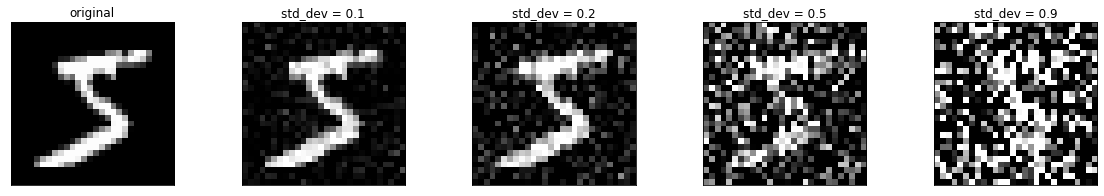

In [25]:
plt.figure(figsize=(20, 3))

ax = plt.subplot(1, 5, 1)
plt.imshow(conv_train_input[0], cmap='gray')
plt.title("original")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 5, 2)
plt.imshow(std1_train[0], cmap='gray')
plt.title("std_dev = 0.1")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 5, 3)
plt.imshow(std2_train[0], cmap='gray')
plt.title("std_dev = 0.2")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 5, 4)
plt.imshow(std5_train[0], cmap='gray')
plt.title("std_dev = 0.5")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 5, 5)
plt.imshow(std9_train[0], cmap='gray')
plt.title("std_dev = 0.9")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

Clearly with a small standard deviation a human can tell, but it becomes significantly harder with a high standard deviation.  Note that the range of our centered data is $\left[ -0.5, 0.5 \right]$, so a standard deviation of $0.9$ is quite high.

Again, we will test the previously trained model against the varying degrees of difficulty:

In [26]:
loss, acc = conv_model.evaluate(std1_test, test_class, verbose=0)
print('With noise with a std_dev=0.1, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = conv_model.evaluate(std2_test, test_class, verbose=0)
print('With noise with a std_dev=0.2, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = conv_model.evaluate(std5_test, test_class, verbose=0)
print('With noise with a std_dev=0.5, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = conv_model.evaluate(std9_test, test_class, verbose=0)
print('With noise with a std_dev=0.9, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

With noise with a std_dev=0.1, this model had a loss of 0.035 and a total accuracy of 98.95%.
With noise with a std_dev=0.2, this model had a loss of 0.051 and a total accuracy of 98.44%.
With noise with a std_dev=0.5, this model had a loss of 1.298 and a total accuracy of 57.25%.
With noise with a std_dev=0.9, this model had a loss of 3.429 and a total accuracy of 15.7%.


We can see that by the nature of being a convolutional neural network we are able to deal with some of the noise, however once it is increased the model clearly falls apart.

We will train 4 models against the various amounts of noise and again compare them to each other and the original model that was not trained on noise.

In [27]:
std1_model = conv_model_maker()
std2_model = conv_model_maker()
std5_model = conv_model_maker()
std9_model = conv_model_maker()

In [28]:
std1_model.fit(std1_train, train_class, batch_size=batch_size, epochs=epochs, verbose=0,
      validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[callback]);
std2_model.fit(std2_train, train_class, batch_size=batch_size, epochs=epochs, verbose=0,
      validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[callback]);
std5_model.fit(std5_train, train_class, batch_size=batch_size, epochs=epochs, verbose=0,
      validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[callback]);
std9_model.fit(std9_train, train_class, batch_size=batch_size, epochs=epochs, verbose=0,
      validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[callback]);

In [29]:
print('For the model trained on data with a noise of 0.1:')
loss, acc = std1_model.evaluate(conv_test_input, test_class, verbose=0)
print('With no noise, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std1_model.evaluate(std1_test, test_class, verbose=0)
print('With noise with a std_dev=0.1, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std1_model.evaluate(std2_test, test_class, verbose=0)
print('With noise with a std_dev=0.2, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std1_model.evaluate(std5_test, test_class, verbose=0)
print('With noise with a std_dev=0.5, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std1_model.evaluate(std9_test, test_class, verbose=0)
print('With noise with a std_dev=0.9, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

For the model trained on data with a noise of 0.1:
With no noise, this model had a loss of 0.037 and a total accuracy of 99.03%.
With noise with a std_dev=0.1, this model had a loss of 0.036 and a total accuracy of 99.06%.
With noise with a std_dev=0.2, this model had a loss of 0.041 and a total accuracy of 98.82%.
With noise with a std_dev=0.5, this model had a loss of 0.449 and a total accuracy of 85.1%.
With noise with a std_dev=0.9, this model had a loss of 1.906 and a total accuracy of 43.22%.


In [30]:
print('For the model trained on data with a noise of 0.2:')
loss, acc = std2_model.evaluate(conv_test_input, test_class, verbose=0)
print('With no noise, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std2_model.evaluate(std1_test, test_class, verbose=0)
print('With noise with a std_dev=0.1, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std2_model.evaluate(std2_test, test_class, verbose=0)
print('With noise with a std_dev=0.2, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std2_model.evaluate(std5_test, test_class, verbose=0)
print('With noise with a std_dev=0.5, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std2_model.evaluate(std9_test, test_class, verbose=0)
print('With noise with a std_dev=0.9, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

For the model trained on data with a noise of 0.2:
With no noise, this model had a loss of 0.036 and a total accuracy of 99.08%.
With noise with a std_dev=0.1, this model had a loss of 0.037 and a total accuracy of 99.03%.
With noise with a std_dev=0.2, this model had a loss of 0.039 and a total accuracy of 98.95%.
With noise with a std_dev=0.5, this model had a loss of 0.32 and a total accuracy of 89.22%.
With noise with a std_dev=0.9, this model had a loss of 1.91 and a total accuracy of 41.32%.


In [31]:
print('For the model trained on data with a noise of 0.5:')
loss, acc = std5_model.evaluate(conv_test_input, test_class, verbose=0)
print('With no noise, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std5_model.evaluate(std1_test, test_class, verbose=0)
print('With noise with a std_dev=0.1, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std5_model.evaluate(std2_test, test_class, verbose=0)
print('With noise with a std_dev=0.2, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std5_model.evaluate(std5_test, test_class, verbose=0)
print('With noise with a std_dev=0.5, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std5_model.evaluate(std9_test, test_class, verbose=0)
print('With noise with a std_dev=0.9, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

For the model trained on data with a noise of 0.5:
With no noise, this model had a loss of 0.057 and a total accuracy of 98.82%.
With noise with a std_dev=0.1, this model had a loss of 0.056 and a total accuracy of 98.83%.
With noise with a std_dev=0.2, this model had a loss of 0.052 and a total accuracy of 98.84%.
With noise with a std_dev=0.5, this model had a loss of 0.116 and a total accuracy of 96.79%.
With noise with a std_dev=0.9, this model had a loss of 1.105 and a total accuracy of 68.95%.


In [32]:
print('For the model trained on data with a noise of 0.9:')
loss, acc = std9_model.evaluate(conv_test_input, test_class, verbose=0)
print('With no noise, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std9_model.evaluate(std1_test, test_class, verbose=0)
print('With noise with a std_dev=0.1, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std9_model.evaluate(std2_test, test_class, verbose=0)
print('With noise with a std_dev=0.2, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std9_model.evaluate(std5_test, test_class, verbose=0)
print('With noise with a std_dev=0.5, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = std9_model.evaluate(std9_test, test_class, verbose=0)
print('With noise with a std_dev=0.9, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

For the model trained on data with a noise of 0.9:
With no noise, this model had a loss of 0.119 and a total accuracy of 96.92%.
With noise with a std_dev=0.1, this model had a loss of 0.115 and a total accuracy of 96.9%.
With noise with a std_dev=0.2, this model had a loss of 0.114 and a total accuracy of 96.72%.
With noise with a std_dev=0.5, this model had a loss of 0.146 and a total accuracy of 95.72%.
With noise with a std_dev=0.9, this model had a loss of 0.434 and a total accuracy of 85.83%.


These results are very good.  With the noise getting as big as it is, even a human's accuracy would go down a bit, yet these neural networks are still able to do very well across the board without losing a lot of accuracy when it comes to the less noisy data.

# Autoencoders

An encoder is essentially some algorithm that takes some piece of data and returns a smaller amount of data in such a way that one can decode it to recover the original data.  This can be used as a great way to help out with storage as well as (though much less likely) a naive form of encryption.

An autoencoder is the deep learning spin on this.  The neural network attempts to project the data to as few dimensions as possible (typically called the latent dimension) while still having the ability to decode it back to (close to) the original data.

Here we will only attempt to shrink the data to 32-dimensional vectors, although one could easily play around with both the latent dimension size and size of the network to likely do better.

You can also use autoencoders for anomaly detection, looking at data to see whether it is real, and feature extraction, a way to look at how changing particular features changes the image itself.  The latter will be explored more in the next section with a stronger version of autoencoders.

Below is an example of a Convolutional Autoencoder.  Utilizing the convolutional layers helps for the same reasons as earlier, specifically with denoising the encoded data.  Note that for the decoder the transpositional convolutional layers simply mirror the encoded convolutional layers.

Note: The Autoencoder and Variational Autoencoder code is inspired by tensorflow's tutorials.

In [33]:
latent_dim = 32

class Autoencoder(keras.models.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = keras.Sequential([
            keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=(2,2), activation=keras.activations.relu, input_shape=(28,28,1)),
            keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu),
            keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation=keras.activations.relu),
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation=keras.activations.relu),
            keras.layers.Dense(latent_dim, activation=keras.activations.linear)
        ])
        self.decoder = keras.Sequential([
            keras.layers.Dense(64, activation=keras.activations.relu, input_shape=(latent_dim,)),
            keras.layers.Dense(6*6*32, activation=keras.activations.relu),
            keras.layers.Reshape((6,6,32)), # analogous to flattening
            keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(1,1), activation=keras.activations.relu),
            keras.layers.Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu),
            keras.layers.Conv2DTranspose(filters=16, kernel_size=(5,5), strides=(2,2), activation=keras.activations.relu),
            # 1 filter so that we only have 1 image.  Also no activation function here to allow negative outputs
            keras.layers.Conv2DTranspose(filters=1, kernel_size=(2,2), strides=(1,1))
        ])
        
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [34]:
autoencoder = Autoencoder(latent_dim)
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 12, 12, 16)        416       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 32)          12832     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
flatten_9 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                73792     
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
Total params: 98,368
Trainable params: 98,368
Non-trainable params: 0
__________________________________________________

Note here that we use Mean Squared Error for our loss.  There has been some research into determining how similar 2 images are, but for our purposes with simple images and a relatively simple autoencoder, MSE will be fine.

In [35]:
autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

Our goal is to reproduce an identical image, so instead of using the classes as the output we simply use the initial training data.  Because of this, we change our early stopping criteria to checking the validation loss instead of validation accuracy.

In [36]:
encoding_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.0005, patience=3)
autoencoder.fit(conv_train_input, conv_train_input, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[encoding_callback]);

Epoch 1/20
750/750 [==============================] - 26s 34ms/step - loss: 0.0739 - val_loss: 0.0157
Epoch 2/20
750/750 [==============================] - 24s 32ms/step - loss: 0.0140 - val_loss: 0.0107
Epoch 3/20
750/750 [==============================] - 24s 32ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 4/20
750/750 [==============================] - 25s 33ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 5/20
750/750 [==============================] - 24s 32ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 6/20
750/750 [==============================] - 24s 32ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 7/20
750/750 [==============================] - 24s 32ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 8/20
750/750 [==============================] - 25s 33ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 9/20
750/750 [==============================] - 24s 32ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 10/20
750/750 [==============================] - 27s 36ms/step - loss: 0.006

Now that the model has been trained, we will encode and decode our images and see how well our model does.

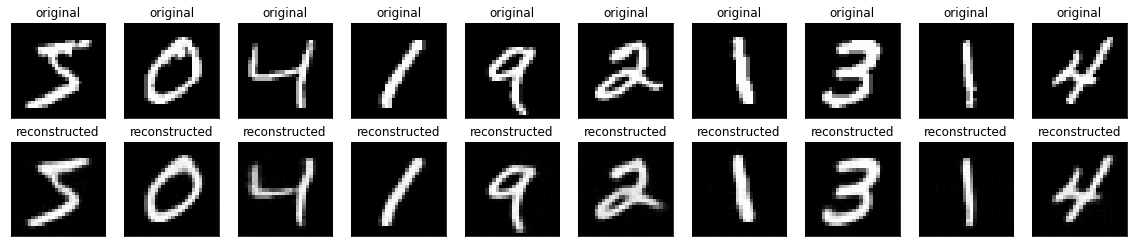

In [37]:
n = 10 # number of images to view

encoded_imgs = autoencoder.encoder(conv_train_input[:n]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
decoded_imgs = tf.clip_by_value(decoded_imgs, -0.5, 0.5)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(conv_train_input[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As you can see encoder is able to replicate the original images to a high degree of accuracy even though we are reducing the images to being 64-dimensional vectors.

### Denoising Data

An added benefit of Autoencoders is that they are able to help out with denoising data.  Even without specifically training on nosiy data we are able to do reasonably well on slightly noisy data, although the model falls apart with more noise.

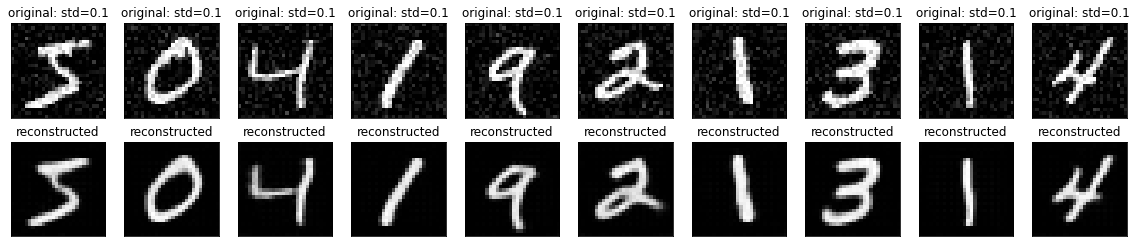

In [38]:
n = 10 # number of images to view

encoded_imgs = autoencoder.encoder(std1_train[:n]).numpy()
std1_decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std1_decoded_imgs = tf.clip_by_value(std1_decoded_imgs, -0.5, 0.5)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(std1_train[i])
    plt.title("original: std=0.1")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(std1_decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

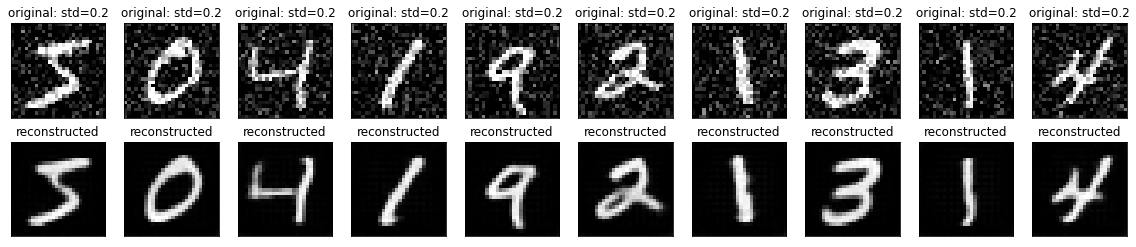

In [39]:
n = 10 # number of images to view

encoded_imgs = autoencoder.encoder(std2_train[:n]).numpy()
std2_decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std2_decoded_imgs = tf.clip_by_value(std2_decoded_imgs, -0.5, 0.5)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(std2_train[i])
    plt.title("original: std=0.2")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(std2_decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

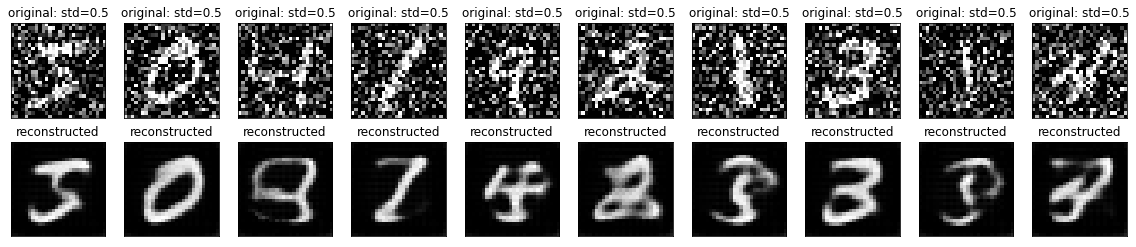

In [40]:
encoded_imgs = autoencoder.encoder(std5_train[:n]).numpy()
std5_decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std5_decoded_imgs = tf.clip_by_value(std5_decoded_imgs, -0.5, 0.5)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(std5_train[i])
    plt.title("original: std=0.5")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(std5_decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

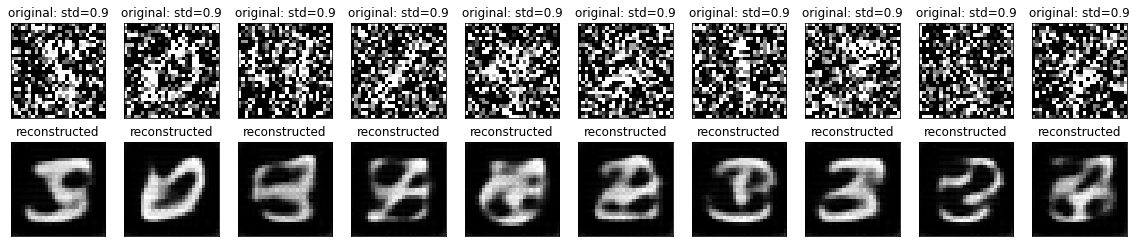

In [41]:
encoded_imgs = autoencoder.encoder(std9_train[:n]).numpy()
std9_decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std9_decoded_imgs = tf.clip_by_value(std9_decoded_imgs, -0.5, 0.5)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(std9_train[i])
    plt.title("original: std=0.9")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(std9_decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

First, we will retrain the autoencoder with the noisy data as the input and clean data as the outputs.

In [42]:
std1_autoencoder = Autoencoder(latent_dim)
std1_autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())
std2_autoencoder = Autoencoder(latent_dim)
std2_autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())
std5_autoencoder = Autoencoder(latent_dim)
std5_autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())
std9_autoencoder = Autoencoder(latent_dim)
std9_autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

In [43]:
std1_autoencoder.fit(std1_train, conv_train_input, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[encoding_callback]);
std2_autoencoder.fit(std2_train, conv_train_input, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[encoding_callback]);
std5_autoencoder.fit(std5_train, conv_train_input, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[encoding_callback]);
std9_autoencoder.fit(std9_train, conv_train_input, batch_size=batch_size, epochs=epochs, verbose=0,
          validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[encoding_callback]);

The following images are the reconstructed images given a set amount of noise.

Model trained on std_dev=0.1:


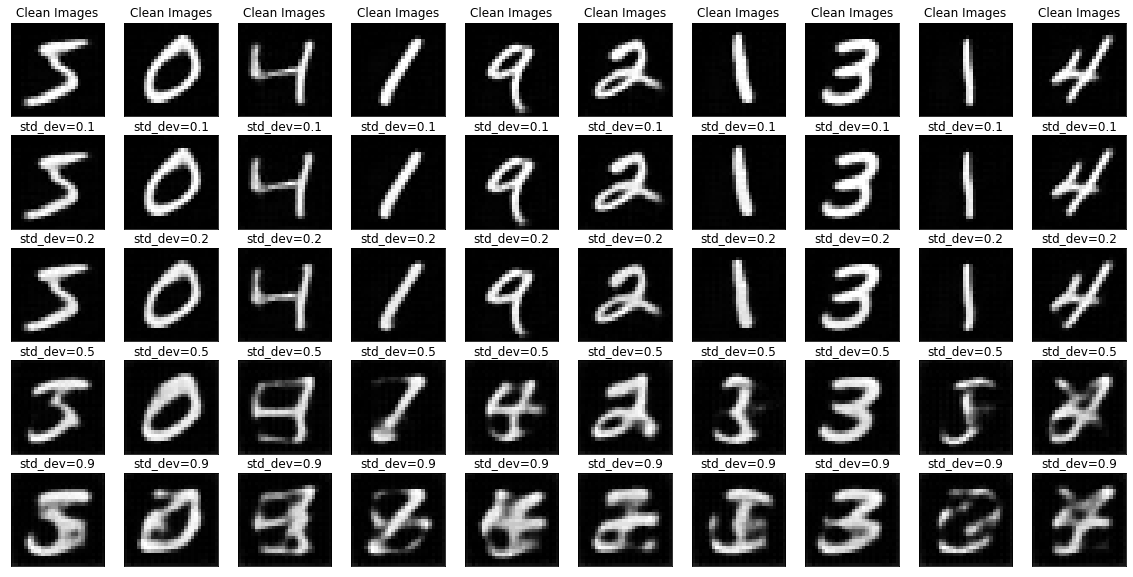

In [44]:
encoded_imgs = std1_autoencoder.encoder(conv_train_input[:n]).numpy()
clean_decoded_imgs = std1_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
clean_decoded_imgs = tf.clip_by_value(clean_decoded_imgs, -0.5, 0.5)

encoded_imgs = std1_autoencoder.encoder(std1_train[:n]).numpy()
std1_decoded_imgs = std1_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std1_decoded_imgs = tf.clip_by_value(std1_decoded_imgs, -0.5, 0.5)

encoded_imgs = std1_autoencoder.encoder(std2_train[:n]).numpy()
std2_decoded_imgs = std1_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std2_decoded_imgs = tf.clip_by_value(std2_decoded_imgs, -0.5, 0.5)

encoded_imgs = std1_autoencoder.encoder(std5_train[:n]).numpy()
std5_decoded_imgs = std1_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std5_decoded_imgs = tf.clip_by_value(std5_decoded_imgs, -0.5, 0.5)

encoded_imgs = std1_autoencoder.encoder(std9_train[:n]).numpy()
std9_decoded_imgs = std1_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std9_decoded_imgs = tf.clip_by_value(std9_decoded_imgs, -0.5, 0.5)

print('Model trained on std_dev=0.1:')

plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(clean_decoded_imgs[i])
    plt.title("Clean Images")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(std1_decoded_imgs[i])
    plt.title("std_dev=0.1")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + 2*n)
    plt.imshow(std2_decoded_imgs[i])
    plt.title("std_dev=0.2")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + 3*n)
    plt.imshow(std5_decoded_imgs[i])
    plt.title("std_dev=0.5")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(5, n, i + 1 + 4*n)
    plt.imshow(std9_decoded_imgs[i])
    plt.title("std_dev=0.9")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()

Model trained on std_dev=0.2:


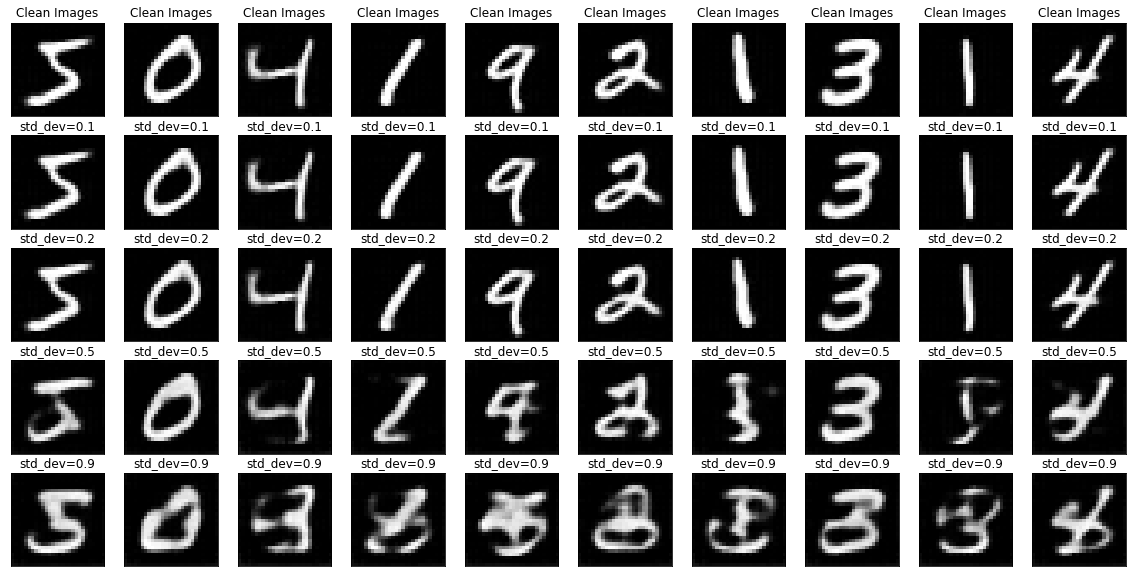

In [45]:
encoded_imgs = std2_autoencoder.encoder(conv_train_input[:n]).numpy()
clean_decoded_imgs = std2_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
clean_decoded_imgs = tf.clip_by_value(clean_decoded_imgs, -0.5, 0.5)

encoded_imgs = std2_autoencoder.encoder(std1_train[:n]).numpy()
std1_decoded_imgs = std2_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std1_decoded_imgs = tf.clip_by_value(std1_decoded_imgs, -0.5, 0.5)

encoded_imgs = std2_autoencoder.encoder(std2_train[:n]).numpy()
std2_decoded_imgs = std2_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std2_decoded_imgs = tf.clip_by_value(std2_decoded_imgs, -0.5, 0.5)

encoded_imgs = std2_autoencoder.encoder(std5_train[:n]).numpy()
std5_decoded_imgs = std2_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std5_decoded_imgs = tf.clip_by_value(std5_decoded_imgs, -0.5, 0.5)

encoded_imgs = std2_autoencoder.encoder(std9_train[:n]).numpy()
std9_decoded_imgs = std2_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std9_decoded_imgs = tf.clip_by_value(std9_decoded_imgs, -0.5, 0.5)

print('Model trained on std_dev=0.2:')

plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(clean_decoded_imgs[i])
    plt.title("Clean Images")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(std1_decoded_imgs[i])
    plt.title("std_dev=0.1")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + 2*n)
    plt.imshow(std2_decoded_imgs[i])
    plt.title("std_dev=0.2")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + 3*n)
    plt.imshow(std5_decoded_imgs[i])
    plt.title("std_dev=0.5")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(5, n, i + 1 + 4*n)
    plt.imshow(std9_decoded_imgs[i])
    plt.title("std_dev=0.9")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()

Model trained on std_dev=0.5:


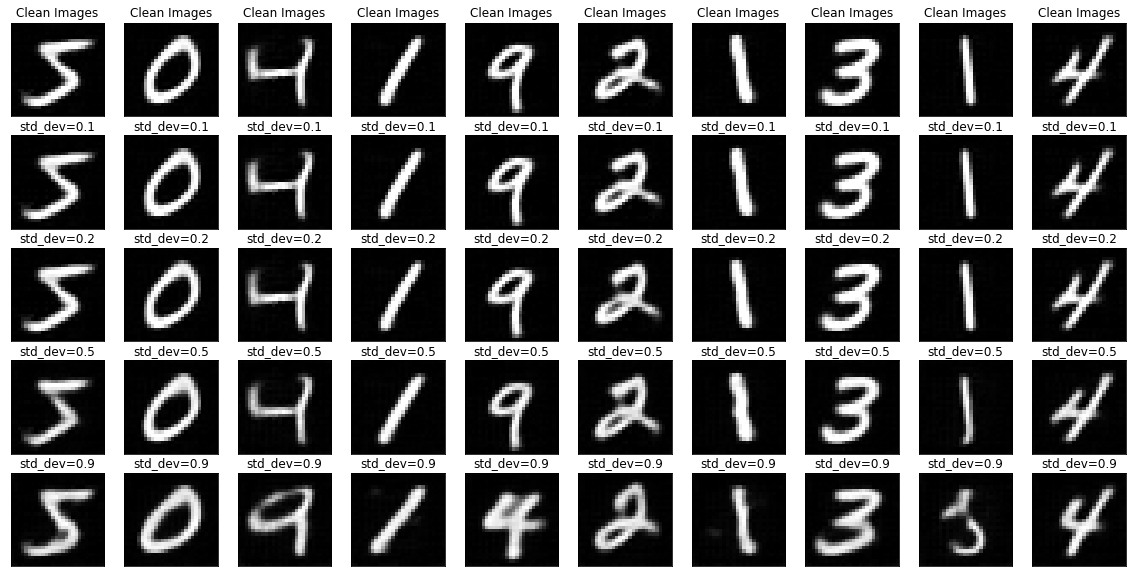

In [46]:
encoded_imgs = std5_autoencoder.encoder(conv_train_input[:n]).numpy()
clean_decoded_imgs = std5_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
clean_decoded_imgs = tf.clip_by_value(clean_decoded_imgs, -0.5, 0.5)

encoded_imgs = std5_autoencoder.encoder(std1_train[:n]).numpy()
std1_decoded_imgs = std5_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std1_decoded_imgs = tf.clip_by_value(std1_decoded_imgs, -0.5, 0.5)

encoded_imgs = std5_autoencoder.encoder(std2_train[:n]).numpy()
std2_decoded_imgs = std5_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std2_decoded_imgs = tf.clip_by_value(std2_decoded_imgs, -0.5, 0.5)

encoded_imgs = std5_autoencoder.encoder(std5_train[:n]).numpy()
std5_decoded_imgs = std5_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std5_decoded_imgs = tf.clip_by_value(std5_decoded_imgs, -0.5, 0.5)

encoded_imgs = std5_autoencoder.encoder(std9_train[:n]).numpy()
std9_decoded_imgs = std5_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std9_decoded_imgs = tf.clip_by_value(std9_decoded_imgs, -0.5, 0.5)

print('Model trained on std_dev=0.5:')

plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(clean_decoded_imgs[i])
    plt.title("Clean Images")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(std1_decoded_imgs[i])
    plt.title("std_dev=0.1")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + 2*n)
    plt.imshow(std2_decoded_imgs[i])
    plt.title("std_dev=0.2")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + 3*n)
    plt.imshow(std5_decoded_imgs[i])
    plt.title("std_dev=0.5")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(5, n, i + 1 + 4*n)
    plt.imshow(std9_decoded_imgs[i])
    plt.title("std_dev=0.9")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()

Model trained on std_dev=0.9:


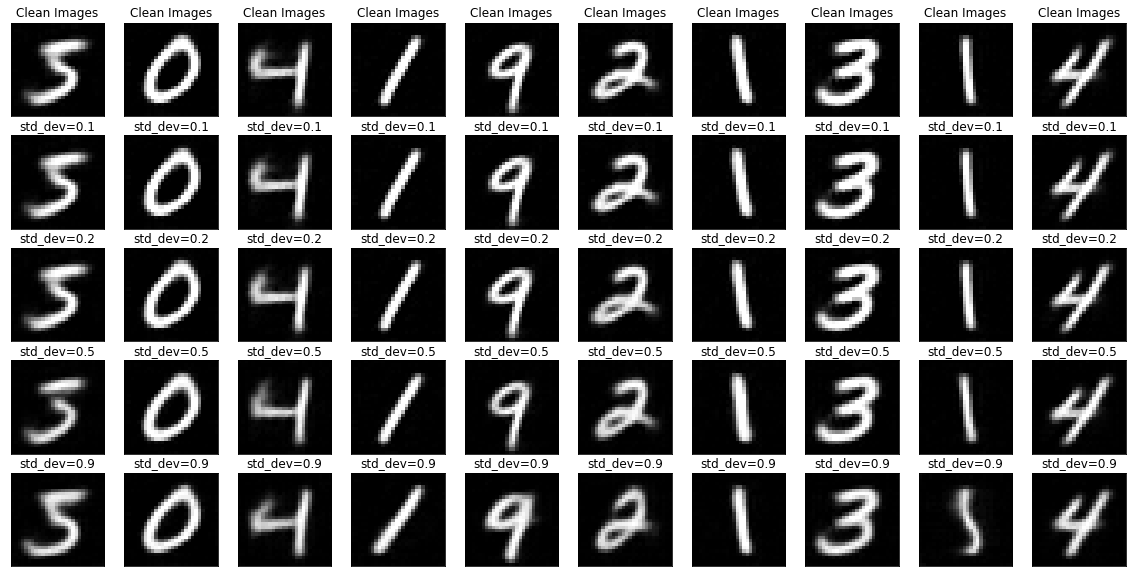

In [47]:
encoded_imgs = std9_autoencoder.encoder(conv_train_input[:n]).numpy()
clean_decoded_imgs = std9_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
clean_decoded_imgs = tf.clip_by_value(clean_decoded_imgs, -0.5, 0.5)

encoded_imgs = std9_autoencoder.encoder(std1_train[:n]).numpy()
std1_decoded_imgs = std9_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std1_decoded_imgs = tf.clip_by_value(std1_decoded_imgs, -0.5, 0.5)

encoded_imgs = std9_autoencoder.encoder(std2_train[:n]).numpy()
std2_decoded_imgs = std9_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std2_decoded_imgs = tf.clip_by_value(std2_decoded_imgs, -0.5, 0.5)

encoded_imgs = std9_autoencoder.encoder(std5_train[:n]).numpy()
std5_decoded_imgs = std9_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std5_decoded_imgs = tf.clip_by_value(std5_decoded_imgs, -0.5, 0.5)

encoded_imgs = std9_autoencoder.encoder(std9_train[:n]).numpy()
std9_decoded_imgs = std9_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std9_decoded_imgs = tf.clip_by_value(std9_decoded_imgs, -0.5, 0.5)

print('Model trained on std_dev=0.9:')

plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(clean_decoded_imgs[i])
    plt.title("Clean Images")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(std1_decoded_imgs[i])
    plt.title("std_dev=0.1")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + 2*n)
    plt.imshow(std2_decoded_imgs[i])
    plt.title("std_dev=0.2")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(5, n, i + 1 + 3*n)
    plt.imshow(std5_decoded_imgs[i])
    plt.title("std_dev=0.5")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(5, n, i + 1 + 4*n)
    plt.imshow(std9_decoded_imgs[i])
    plt.title("std_dev=0.9")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()

Recalling that the data with std_dev=0.9 looks like the image below, it is remarkable how well this final model trained on such data is able to clean the images of all degrees of noise.  In fact it does so well that the original CNN trained on clean data is able to perform reasonably well on this cleaned data despite doing terribly beforehand:

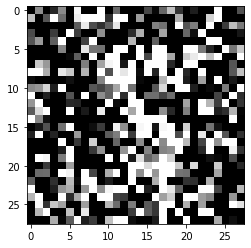

In [48]:
plt.imshow(std9_train[0], cmap='gray');

In [49]:
encoded_imgs = std9_autoencoder.encoder(std9_train).numpy()
std9_decoded_imgs = std9_autoencoder.decoder(encoded_imgs).numpy()
# we aren't guaranteed that the decoded images are between -0.5 and 0.5 so we clip them ourselves
std9_decoded_imgs = tf.clip_by_value(std9_decoded_imgs, -0.5, 0.5)
loss, acc = conv_model.evaluate(std9_train, train_class, verbose=0)
print('Prior to decoding the noisy images with a std_dev=0.9, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))
loss, acc = conv_model.evaluate(std9_decoded_imgs, train_class, verbose=0)
print('After decoding the noisy images with a std_dev=0.9, this model had a loss of {} and a total accuracy of {}%.'.format(round(loss, 3), round(acc*100, 4)))

Prior to decoding the noisy images with a std_dev=0.9, this model had a loss of 3.458 and a total accuracy of 15.875%.
After decoding the noisy images with a std_dev=0.9, this model had a loss of 0.738 and a total accuracy of 85.9817%.


As an additional note, autoencoders are interesting when it comes to efficiency and speed.  The norm for neural networks is that training can take a while and even simply using a trained network can be computationally taxing due to networks often being massive in practice.  Autoencoders, however, only require a decoder once information is decoded, i.e. data is encoded server side and sent to individuals who simply need to decode it, so all of the computational difficulty for the user is held in the decoding phase.  With certain types of data, it may be possible to have a strong enough encoder network that the decoder network can be quite small, helping significantly with a potential user's experience.

### Clustering Algorithms for Classification with Autoencoders

Yet another application of autoencoders is that one can utilize them for classification even in an unsupervised setting.  If we have some intuition as to how many different classes there are, we can utilize clustering algorithms to categorize data based on their encodings.  Using the encodings is useful as images are very difficult to work with directly since there can be many transformations of the same image that can be stored completely differently in an array.

Here, we will encode our data (while completely ignoring the existence of noise), apply the K-Means clustering algorithm, and test these against the test data.

In [50]:
encoded_data = std9_autoencoder.encoder(conv_train_input)

In [230]:
def dist(x,y):
    return np.linalg.norm(x-y, 2)

def find_centroid(point, centers):
    distances = [dist(point, center) for center in centers]
    return np.argmin(distances)

def K_Means(data, k, eps=0.01, max_steps=50):
    
    start_time = time.time()
    
    centroids = np.random.choice([i for i in range(data.shape[0])], k)  # choose n random starting centroids
    centroids = np.array([data[i] for i in centroids])
    
    delta = np.infty
    step = 1
    
    while delta > eps and step < max_steps:
        print('Total Time Elapsed: {}s,  Step: {},  Delta: {}'.format(round(time.time()-start_time, 2), step, delta))
        clear_output(wait=True)
        baskets = [[] for i in range(k)]
        
        for i in range(data.shape[0]):
            point = data[i]
            baskets[find_centroid(point, centroids)].append(point)
            
        new_centroids = np.array([np.mean(baskets[i], axis=0) for i in range(k)])
        
        step += 1
        delta = dist(centroids, new_centroids)
        centroids = new_centroids
        
    print('Total Time Elapsed: {}s,  Total Steps Taken: {},  Final Delta: {}'.format(round(time.time()-start_time, 2), step, delta))
    return centroids

centroids = K_Means(encoded_data, 10)

Total Time Elapsed: 1308.57s,  Total Steps Taken: 50,  Final Delta: 0.0032590520568192005


In [231]:
# store indices in each group according to the centorids
baskets = [[] for i in range(10)]
for i in range(encoded_data.shape[0]):
    point = encoded_data[i]
    baskets[find_centroid(point, centroids)].append(i)
    
basket_classes = [{i:0 for i in range(10)} for _ in range(10)]
for i in range(10):
    for index in baskets[i]:
        basket_classes[i][train_class[index]] += 1
    print(basket_classes[i])

centroid_classes = [sorted(basket_classes[i].items(), key=lambda item: item[1])[-1][0] for i in range(10)]
print(centroid_classes)

{0: 29, 1: 21, 2: 4388, 3: 313, 4: 19, 5: 13, 6: 14, 7: 48, 8: 30, 9: 19}
{0: 5, 1: 13, 2: 56, 3: 49, 4: 1825, 5: 38, 6: 0, 7: 4469, 8: 105, 9: 2633}
{0: 1946, 1: 0, 2: 292, 3: 386, 4: 31, 5: 1044, 6: 310, 7: 29, 8: 189, 9: 32}
{0: 64, 1: 2348, 2: 712, 3: 609, 4: 497, 5: 1072, 6: 732, 7: 388, 8: 494, 9: 351}
{0: 169, 1: 6, 2: 74, 3: 3653, 4: 3, 5: 2004, 6: 45, 7: 28, 8: 1229, 9: 72}
{0: 162, 1: 0, 2: 42, 3: 6, 4: 170, 5: 38, 6: 4674, 7: 2, 8: 26, 9: 8}
{0: 282, 1: 67, 2: 160, 3: 986, 4: 7, 5: 984, 6: 52, 7: 15, 8: 3464, 9: 50}
{0: 12, 1: 2, 2: 38, 3: 103, 4: 3205, 5: 205, 6: 24, 7: 1145, 8: 250, 9: 2741}
{0: 0, 1: 4285, 2: 170, 3: 7, 4: 84, 5: 8, 6: 25, 7: 133, 8: 41, 9: 11}
{0: 3254, 1: 0, 2: 26, 3: 19, 4: 1, 5: 15, 6: 42, 7: 8, 8: 23, 9: 32}
[2, 7, 0, 1, 3, 6, 8, 4, 1, 0]


In [232]:
encoded_test = std9_autoencoder.encoder(conv_test_input).numpy()
right_list = [0 for i in range(encoded_test.shape[0])]

for i in range(encoded_test.shape[0]):
    point = encoded_test[i]
    if centroid_classes[find_centroid(point, centroids)] == test_class[i]:
        right_list[i] = 1

print('The total accuracy of this clustering model on the test data is {}%.'.format(round(np.mean(right_list)*100, 3)))

The total accuracy of this clustering model on the test data is 60.55%.


Obviously this is not doing nearly as well as our models previously did for classification.  However, this was done with absolutely no knowledge of what the true values of each image were while training.  In fact, truly the only assumption made in the entire process was that there are 10 classes (one for each digit), which would be incredibly easy to figure out just be skimming through the data, so as an unsupervised algorithm this is doing quite well, especially for K Means.

# Variational Autoencoder

As eluded to earlier, one useful thing you can do with autoencoders is feature extraction.  Ideally, you would want each dimension in the encoding to correspond to a particular feature.  However, with the previous autoencoder, as we can see below this is not the case.  While decreasing the size of the latent space we would be somewhat more likely that each dimension corresponds to a feature, it is still unlikely that a single number in the vector would change very much by itself which would be by far the most interpretable way to do things.

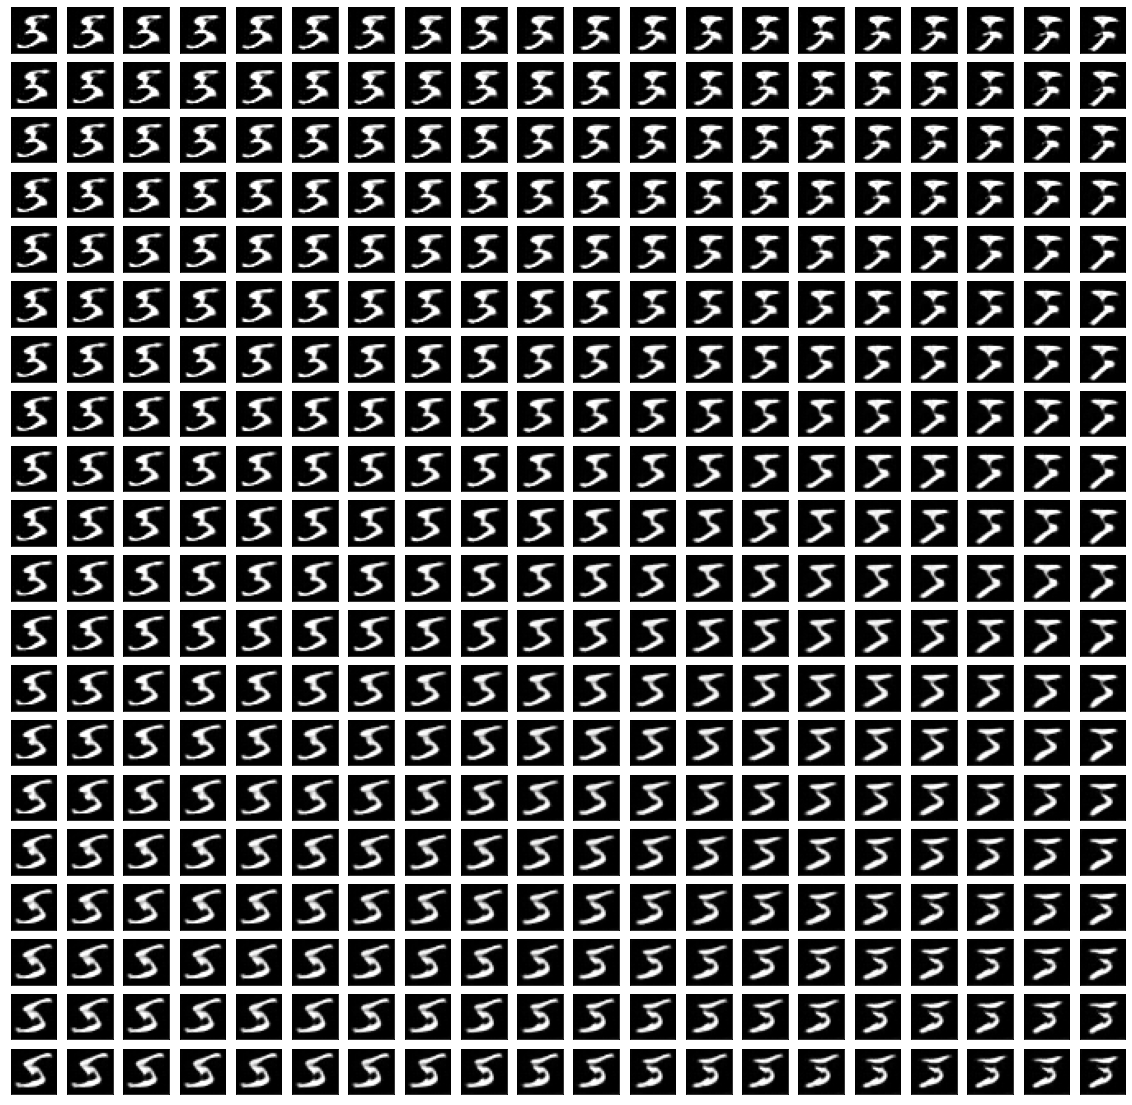

In [53]:
latent_vec = autoencoder.encoder(tf.expand_dims(conv_train_input[0], 0))
latent_vec = np.array(latent_vec)
vec_min = np.min(latent_vec)
vec_max = np.max(latent_vec)

n = 20
my_space = np.linspace(vec_min, vec_max, n)


latent_list = []
for i in range(n**2):
    x,y = divmod(i, n)
    latent_list.append([my_space[x], my_space[y]] + list(latent_vec[0][2:]))

latent_list = tf.convert_to_tensor(latent_list)
decoded_imgs = tf.clip_by_value(autoencoder.decoder(latent_list), -0.5, 0.5)

plt.figure(figsize=(20, 20))
for i in range(n):
    for j in range(n):
        ax = plt.subplot(20, n, 1 + i + j*n)
        plt.imshow(decoded_imgs[i+j*n])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

This is one thing that Variational Autoencoders help with. A Variational Autoencoder aims to do the same thing as a normal autoencoder, except instead of projecting the data to a latent space it projects the data to a normal probability space.  Here we have the encoder output 2 vectors, a mean and standard deviation.

While this does several things for us, most importantly, by sampling from this probability distribution prior to decoding, we have a continuous space that we're training the decoder on instead of only whatever encodings of the tarining data we come up with.  Further, we have an easy way of generating new images that never actually existed previously (which we will talk about later).

There is also an addition to the loss function called the KL Divergence.  This is effectively a regularization term that's intuition is explained excellently [here](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf):

"Intuitively, this loss encourages the encoder to distribute all encodings (for all types of inputs, eg. all MNIST numbers), evenly around the center of the latent space. If it tries to “cheat” by clustering them apart into specific regions, away from the origin, it will be penalized."

In [practice](https://www.tensorflow.org/tutorials/generative/cvae), instead of explicitly computing the KL Divergence we can estimate it reasonably well. (a lot of this code ended up being heavily inspired by this link due to fun bugs that were never found nor understood)

In [54]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [55]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return images.astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_size = 60000
batch_size = 32
test_size = 10000

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

In [56]:
class CVAE(keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = keras.Sequential([
                keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=(2,2), activation=keras.activations.relu, input_shape=(28,28,1)),
                keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu),
                keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation=keras.activations.relu),
                keras.layers.Flatten(),
                keras.layers.Dense(64, activation=keras.activations.relu),
                keras.layers.Dense(2*latent_dim, activation=keras.activations.linear)
            ])

        self.decoder = keras.Sequential([
                keras.layers.Dense(64, activation=keras.activations.relu, input_shape=(latent_dim,)),
                keras.layers.Dense(6*6*32, activation=keras.activations.relu),
                keras.layers.Reshape((6,6,32)), # analogous to flattening
                keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(1,1), activation=keras.activations.relu),
                keras.layers.Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu),
                keras.layers.Conv2DTranspose(filters=16, kernel_size=(5,5), strides=(2,2), activation=keras.activations.relu),
                # 1 filter so that we only have 1 image.  Also no activation function here to allow negative outputs
                keras.layers.Conv2DTranspose(filters=1, kernel_size=(2,2), strides=(1,1))
            ])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [57]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [58]:
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
vae = CVAE(latent_dim)

for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [59]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.show()

Epoch: 10, Test set ELBO: -154.2098846435547, time elapse for current epoch: 40.699s


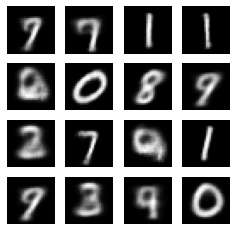

In [61]:
generate_and_save_images(vae, 0, test_sample)

for epoch in range(1, 11):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(vae, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(vae, test_x))
    elbo = -loss.result()
    clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}s'
        .format(epoch, elbo, round(end_time - start_time, 3)))
    generate_and_save_images(vae, epoch, test_sample)

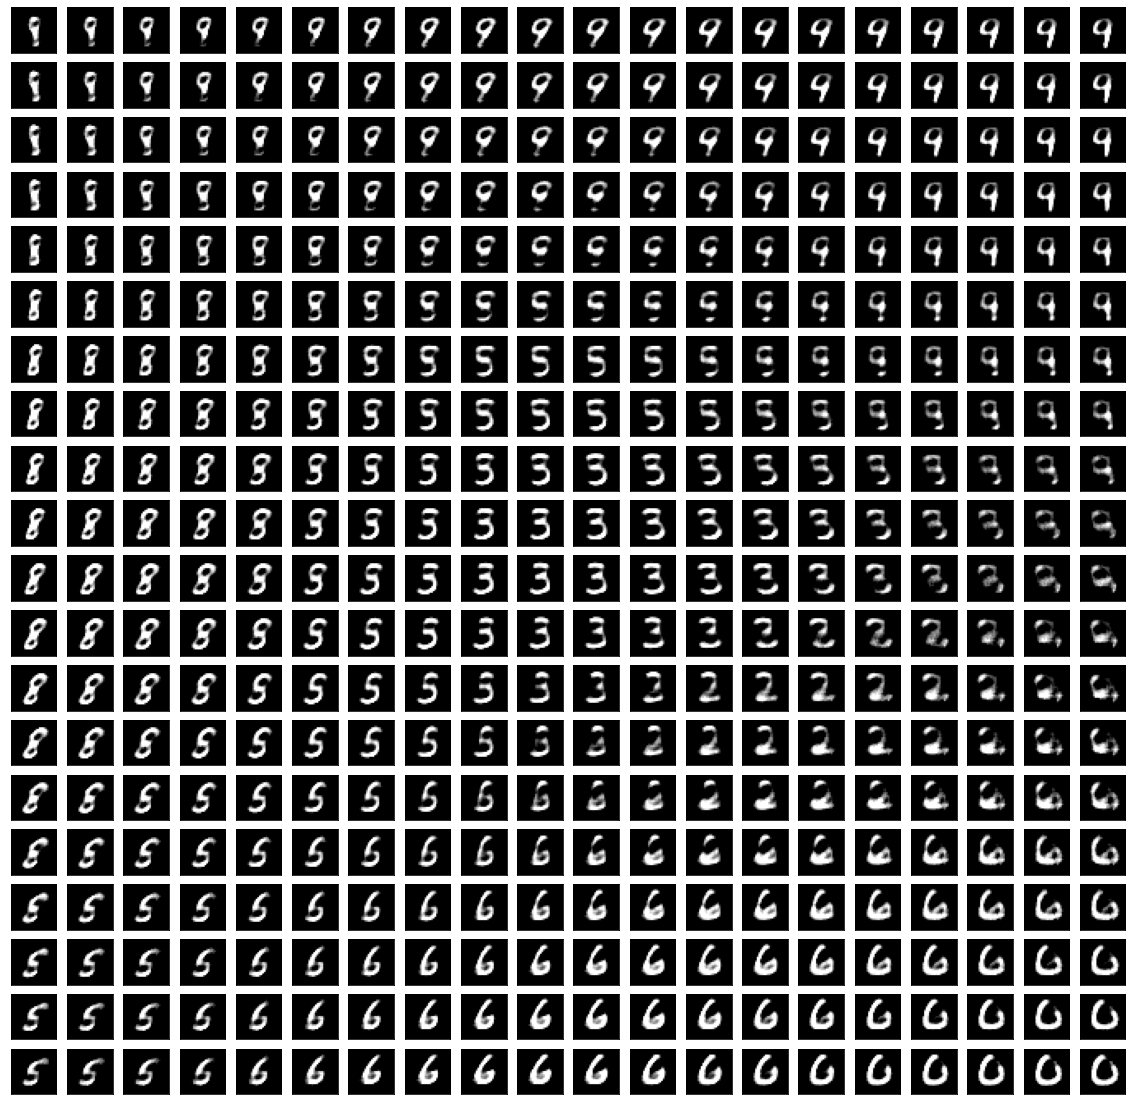

In [62]:
n = 20
my_space = np.linspace(-1, 1, n)


latent_list = []
for i in range(n**2):
    x,y = divmod(i, n)
    latent_list.append([my_space[x], my_space[y]])

latent_list = tf.convert_to_tensor(latent_list)
decoded_imgs = tf.clip_by_value(vae.decode(latent_list), -0.5, 0.5)

plt.figure(figsize=(n, n))
for i in range(n):
    for j in range(n):
        ax = plt.subplot(n, n, 1 + i + j*n)
        plt.imshow(decoded_imgs[i+j*n], cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Don't forget that this VAE is actually encoding images all the way down to a 2-dimensional vector.  Yet, we're getting comparable results to the previous autoencoder.

One particularly interesting thing about VAEs is that with a good VAE (total size and latent_dim), one can find hyperplanes that separate latent vectors based on particular features.  [A popular way to showcase this](https://deepai.org/publication/deep-feature-consistent-variational-autoencoder) is to take images of people and change people's hair color from black to blonde, or even take an image of a man and watch it turn into a corresponding woman.

To show this off here, we'll simply take two images in our data and look at a linspace between them.

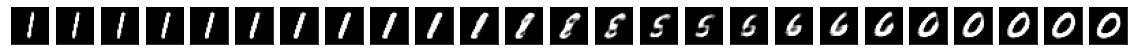

In [76]:
n = 25

im1 = tf.expand_dims(train_images[124], 0)
im2 = tf.expand_dims(train_images[1], 0)

latent1 = np.array(vae.encode(im1)[0]).reshape((2,))
latent2 = np.array(vae.encode(im2)[0]).reshape((2,))

my_space = np.linspace(latent1, latent2, n)

imgs = tf.clip_by_value(vae.decode(my_space), -0.5, 0.5)


plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs[i], cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Generative Adversarial Network (GAN)

While VAEs can be used to generate images, it is not their sole purpose.  However, it is the purpose of Generative Adversarial Networks (GANs).  These work by combining the power of a couple networks; one is designed to create data, while the other is designed to tell whether a datum it is given is real or fake.  Training these together develops a network that can create data that looks real but actually isn't.  This is very cool/creepy when it comes to images of faces, however we'll stick with numbers here.

For the generator, we input random noise and output an image with the same shape as our data.  The loss function here will be a bit more complicated so we don't compile yet.

In [4]:
noise_size = 10 # input vector of size 10 as the noise

def generator_maker():
    model = keras.Sequential([
        keras.layers.Dense(9*9*32, activation=keras.activations.relu, input_shape=(noise_size,)),
        keras.layers.BatchNormalization(),
        
        keras.layers.Reshape((9,9,32)),
        
        keras.layers.Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(filters=24, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(filters=16, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(filters=8, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(filters=1, kernel_size=(4,4), strides=(1,1), activation=keras.activations.sigmoid)
    ])

    return model

In [5]:
generator = generator_maker()
generator.summary()

NameError: name 'keras' is not defined

Prior to training, the generator simply outputs noise;

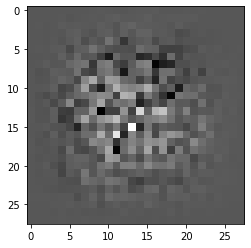

In [68]:
plt.imshow(tf.reshape(generator(np.random.normal(size=(1,noise_size))), (28,28)), cmap='gray');

For the discriminator, we input images and output a single number between 0 and 1, representing the likelihood that the input image is real.

In [69]:
def discriminator_maker():
    model = keras.Sequential([
            keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation=keras.activations.relu, input_shape=(28,28,1)),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation=keras.activations.relu),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation=keras.activations.relu),
            
            keras.layers.Flatten(),
            keras.layers.Dropout(0.1),
            keras.layers.Dense(64, keras.activations.relu),
            keras.layers.Dropout(0.1),
            keras.layers.Dense(32, keras.activations.relu),
            keras.layers.Dense(1, keras.activations.sigmoid)])
    return model

In [70]:
discriminator = discriminator_maker()
discriminator.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_15 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1152)            

Obviously the discriminator has no idea whether an image is real or not yet, so we train it and the generator at the same time.  Theoretically, each will get better at the same rate and eventually the generator will be making life-like images.  In order to do this, we need to define losses for each model.

For the discriminator, it is pretty straightforward; we simply use binary cross entropy as we only care about classifying a single image at a time as real or fake.

For the generator, all we care about is whether we have tricked the discriminator.  So we define the loss to be binary cross entropy based on whether the discriminator is correct based on generated images.

In [71]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [72]:
# For plotting images from the generator throughout the training process
seeds = np.random.normal(size=(10,noise_size))

def plot_images(model, test_seeds):
    imgs = tf.reshape(model(test_seeds), (-1, 28, 28))
    
    plt.figure(figsize=(20, 4))
    for i in range(imgs.shape[0]):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i], cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [73]:
@tf.function
def train_step(images, batch_size):
    noise = np.random.normal(size=(batch_size, noise_size))
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [1]:
def train(dataset, epochs, batch_size):
    true_start = time.time()
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch, batch_size)

        # Produce images for the GIF as we go
        clear_output(wait=True)
        plot_images(generator, seeds)

        print('Time for epoch {} is {}s'.format(epoch + 1, round(time.time()-start, 3)))

    # Generate after the final epoch
    clear_output(wait=True)
    plot_images(generator, seeds)
    print('Total training time: {}s'.format(round(time.time()-true_start, 3)))

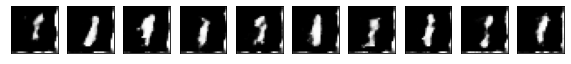

Total training time: 9796.745s


In [75]:
# commented out so I don't accidentally waste another 3 hours
# train(train_dataset, 50, batch_size=batch_size)

# Super Resolution

Super resolution refers to a technique that people randomly do on a lot of crime-related shows that they refer to as "enhancing the picture."  All it is is taking an image or video and raising the resolution and thus quality of the picture.  It's not nearly as easy as they make it seem on tv; to properly train a model, you need high-resolution images and to create their lower-resolution images.  When doing this with deel learning, it can be done with an autoencoder, but one can also just use a few transposed convolutional layers.

Here, we will create lower resolution 14x14 versions of our images and raise their quality back up to the 28x28 they were.

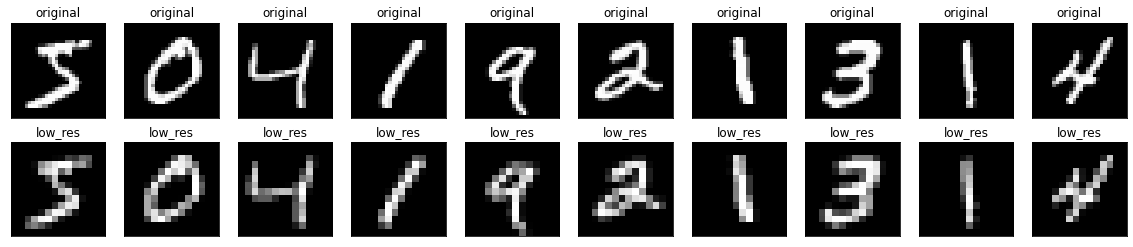

In [15]:
low_res_train = [resize(conv_train_input[i].numpy(), dsize=(14,14)) for i in range(conv_train_input.shape[0])]
low_res_train = tf.clip_by_value(np.array(low_res_train).reshape((-1,14,14,1)), -0.5, 0.5)
    
plt.figure(figsize=(20, 4))
for i in range(10):

    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(conv_train_input[i].numpy().reshape((28,28)), cmap='gray')
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(low_res_train[i].numpy().reshape((14,14)), cmap='gray')
    plt.title("low_res")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [22]:
def super_res_maker():
    model = keras.Sequential([
        keras.layers.Conv2DTranspose(filters=16, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu, input_shape=(14,14,1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(filters=16, kernel_size=(5,5), strides=(1,1), activation=keras.activations.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(filters=1, kernel_size=(3,3), strides=(1,1), activation=keras.activations.sigmoid),
    ])
    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics='accuracy')
    return model

super_res_model = super_res_maker()
super_res_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_11 (Conv2DT (None, 18, 18, 16)        416       
_________________________________________________________________
batch_normalization_9 (Batch (None, 18, 18, 16)        64        
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 22, 22, 32)        12832     
_________________________________________________________________
batch_normalization_10 (Batc (None, 22, 22, 32)        128       
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 26, 26, 16)        12816     
_________________________________________________________________
batch_normalization_11 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 28, 28, 1)        

Note here we add 0.5 to conv_train_input in order to adjust to the range to $\left[ 0,1 \right]$, which is what the model outputs by default due to the sigmoid function at the end.  Here we don't really care about the accuracy so much as the loss since this is a continuous output space (realistically the only "accurate" pixels will be the completely black or white spaces), so we use the same callback function from the autoencoder section that only cares about the validation loss.

In [23]:
super_res_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.0002, patience=3)
super_res_model.fit(low_res_train, conv_train_input+0.5, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_split=0.2, shuffle=True, workers=4, use_multiprocessing=True, callbacks=[super_res_callback]);

Epoch 1/20
750/750 [==============================] - 83s 110ms/step - loss: 0.0548 - accuracy: 0.7852 - val_loss: 0.0111 - val_accuracy: 0.8149
Epoch 2/20
750/750 [==============================] - 82s 109ms/step - loss: 0.0090 - accuracy: 0.8143 - val_loss: 0.0071 - val_accuracy: 0.8153
Epoch 3/20
750/750 [==============================] - 82s 110ms/step - loss: 0.0068 - accuracy: 0.8145 - val_loss: 0.0059 - val_accuracy: 0.8156
Epoch 4/20
750/750 [==============================] - 82s 110ms/step - loss: 0.0057 - accuracy: 0.8148 - val_loss: 0.0054 - val_accuracy: 0.8157
Epoch 5/20
750/750 [==============================] - 84s 112ms/step - loss: 0.0052 - accuracy: 0.8147 - val_loss: 0.0053 - val_accuracy: 0.8157
Epoch 6/20
750/750 [==============================] - 82s 110ms/step - loss: 0.0048 - accuracy: 0.8148 - val_loss: 0.0047 - val_accuracy: 0.8158
Epoch 7/20
750/750 [==============================] - 82s 110ms/step - loss: 0.0046 - accuracy: 0.8152 - val_loss: 0.0045 - val_ac

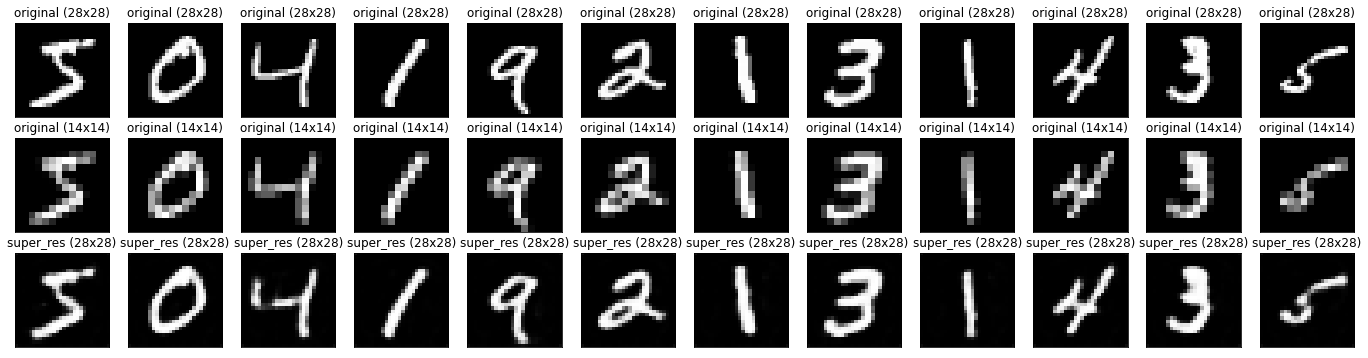

In [24]:
n = 12

originals = conv_train_input[:n].numpy()

low_res_imgs = low_res_train[:n].numpy()

super_res_imgs = super_res_model(low_res_train[:n]).numpy() - 0.5
super_res_imgs = tf.clip_by_value(super_res_imgs, -0.5, 0.5)

plt.figure(figsize=(24, 6))
for i in range(n):
    
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(conv_train_input[i])
    plt.title("original (28x28)")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(low_res_train[i])
    plt.title("original (14x14)")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(super_res_imgs[i])
    plt.title("super_res (28x28)")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()